# 6장 특징 추출

이미지에서 라인, 코너, 특징점 과 같은 특징 추출 방법을 학습한다.

## SIFT

SIFT(scale-invariant feature transform)는 이미지 파리미드를 이용해서 크기 변화에 따른 특징 검출의 문제를 해결한 알고리즘이다. SIFT는 특허권이 있어 상업적 사용에 제약이 있다. 

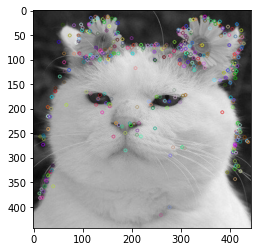

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('./img/cat-01.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
img = cv2.drawKeypoints(gray, kp, img)
plt.imshow(img)
plt.show()

In [ ]:
from skimage.io import imread
from skimage.color import rgb2ycbcr, gray2rgb
image = imread('images/skin.png')
proc_image = np.reshape(rgb2ycbcr(image), (-1, 3))
skin_score = skin_gmm.score_samples(proc_image[...,1:])
not_skin_score = not_skin_gmm.score_samples(proc_image[...,1:])
result = skin_score > not_skin_score
result = result.reshape(image.shape[0], image.shape[1])
result = np.bitwise_and(gray2rgb(255*result.astype(np.uint8)), image)
plt.figure(figsize=(20,10))
plt.subplot(121), plt.imshow(image), plt.axis('off'), plt.title('Original', size=20)
plt.subplot(122), plt.imshow(result), plt.axis('off'), plt.title('Skin Detected and Segmented with GMM', size=20)
plt.show()

In [ ]:
import cv2
# for this problem let's work with opencv 3.4.2.16
print(cv2.__version__)
# 3.4.2
# pip install opencv-contrib-python==3.4.2.16
# pip install opencv-python==3.4.2.16
import numpy as np
from matplotlib import pyplot as plt
import math
import glob

def compute_homography(image1, image2, bff_match=False):

    sift = cv2.xfeatures2d.SIFT_create(edgeThreshold=10, sigma=1.5, contrastThreshold=0.08)
    
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)

    # Brute force matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, trainDescriptors=des2, k=2)

    # Lowes Ratio
    good_matches = []
    for m, n in matches:
        if m.distance < .75 * n.distance:
            good_matches.append(m)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])\
        .reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])\
        .reshape(-1, 1, 2)

    if len(src_pts) > 4:
        H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5)
    else:
        H = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
    return H


def warp_image(image, H):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    h, w, _ = image.shape

    # Find min and max x, y of new image
    p = np.array([[0, w, w, 0], [0, 0, h, h], [1, 1, 1, 1]])
    p_prime = np.dot(H, p)

    yrow = p_prime[1] / p_prime[2]
    xrow = p_prime[0] / p_prime[2]
    ymin = min(yrow)
    xmin = min(xrow)
    ymax = max(yrow)
    xmax = max(xrow)

    # Create a new matrix that removes offset and multiply by homography
    new_mat = np.array([[1, 0, -1 * xmin], [0, 1, -1 * ymin], [0, 0, 1]])
    H = np.dot(new_mat, H)

    # height and width of new image frame
    height = int(round(ymax - ymin))
    width = int(round(xmax - xmin))
    size = (width, height)
    # Do the warp
    warped = cv2.warpPerspective(src=image, M=H, dsize=size)

    return warped, (int(xmin), int(ymin))

def cylindrical_warp_image(img, H):
    
    h, w = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h, w))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h*w, 3) # to homog
    Hinv = np.linalg.inv(H) 
    X = Hinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w*h, 3)
    B = H.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w) | (B[:,1] < 0) | (B[:,1] >= h)] = -1
    B = B.reshape(h,w,-1)
    
    img_rgba = cv2.cvtColor(img,cv2.COLOR_BGR2BGRA) # for transparent borders...
    # warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32), cv2.INTER_AREA, borderMode=cv2.BORDER_TRANSPARENT)

def create_mosaic(images, origins):
    # find central image
    for i in range(0, len(origins)):
        if origins[i] == (0, 0):
            central_index = i
            break

    central_image = images[central_index]
    central_origin = origins[central_index]
    
    # zip origins and images together
    zipped = list(zip(origins, images))
    
    # sort by distance from origin (highest to lowest)
    func = lambda x: math.sqrt(x[0][0] ** 2 + x[0][1] ** 2)
    dist_sorted = sorted(zipped, key=func, reverse=True)
    # sort by x value
    x_sorted = sorted(zipped, key=lambda x: x[0][0])
    # sort by y value
    y_sorted = sorted(zipped, key=lambda x: x[0][1])

    # determine the coordinates in the new frame of the central image
    if x_sorted[0][0][0] > 0:
        cent_x = 0  # leftmost image is central image
    else:
        cent_x = abs(x_sorted[0][0][0])

    if y_sorted[0][0][1] > 0:
        cent_y = 0  # topmost image is central image
    else:
        cent_y = abs(y_sorted[0][0][1])

    # make a new list of the starting points in new frame of each image
    spots = []
    for origin in origins:
        spots.append((origin[0]+cent_x, origin[1] + cent_y))

    zipped = zip(spots, images)

    # get height and width of new frame
    total_height = 0
    total_width = 0

    for spot, image in zipped:
        total_width = max(total_width, spot[0]+image.shape[1])
        total_height = max(total_height, spot[1]+image.shape[0])

    # print "height ", total_height
    # print "width ", total_width

    # new frame of panorama
    stitch = np.zeros((total_height, total_width, 4), np.uint8)

    # stitch images into frame by order of distance
    for image in dist_sorted:
        
        offset_y = image[0][1] + cent_y
        offset_x = image[0][0] + cent_x
        end_y = offset_y + image[1].shape[0]
        end_x = offset_x + image[1].shape[1]
        
        ####
        stitch_cur = stitch[offset_y:end_y, offset_x:end_x, :4]
        stitch_cur[image[1]>0] = image[1][image[1]>0]
        ####
                
        #stitch[offset_y:end_y, offset_x:end_x, :4] = image[1]

    return stitch

def create_panorama(images, center):
    
    h,w,_ = images[0].shape
    f = 1000 # 800
    H = np.array([[f, 0, w/2], [0, f, h/2], [0, 0, 1]])
    for i in range(len(images)):
        images[i] = cylindrical_warp_image(images[i], H)
    
    panorama = None
    for i in range(center):
        print('Stitching images {}, {}'.format(i+1, i+2))
        image_warped, image_origin = warp_image(images[i], compute_homography(images[i + 1], images[i]))
        panorama = create_mosaic([image_warped, images[i+1]], [image_origin, (0,0)])
        images[i + 1] = panorama

    #print('Done left part')

    for i in range(center, len(images)-1):
        print('Stitching images {}, {}'.format(i+1, i+2))
        image_warped, image_origin = warp_image(images[i+1], compute_homography(images[i], images[i + 1]))
        panorama = create_mosaic([images[i], image_warped], [(0,0), image_origin])
        images[i + 1] = panorama

    #print('Done right part')
    return panorama

images = [ cv2.cvtColor(cv2.imread(img), cv2.COLOR_RGB2RGBA) for img in glob.glob('images/victoria*.png')]

plt.figure(figsize=(20,4))
plt.subplots_adjust(top = 0.8, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0.05)
plt.margins(0,0)
for i in range(len(images)):
    plt.subplot(1,len(images),i+1), plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Image {}'.format(i+1), size=15)
plt.suptitle('Images to Stitch', size=20)
plt.show()

center = len(images) // 2
#print(len(images), center)

panorama = create_panorama(images, center)

plt.figure(figsize=(20,8))
plt.subplots_adjust(top = 0.9, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Final Panorama Image', size=15)
plt.show()

## Image Classification with scikit-learn (HOG + Loistic Regression)

In [ ]:
# http://www.vision.caltech.edu/Image_Datasets/Caltech101/
# https://www.kaggle.com/manikg/training-svm-classifier-with-hog-features
%matplotlib inline
import numpy as np
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from glob import glob
from matplotlib import pyplot as plt

images, hog_images = [], []
X, y = [], []
ppc = 16
sz = 200
for dir in glob('images/Caltech101_images/*'):
    image_files = glob(dir + '/*.jpg')
    label = dir.split('\\')[-1]
    print(label, len(image_files))
    for image_file in image_files:
        image = resize(imread(image_file), (sz,sz))
        if len(image.shape) == 2: # if a gray-scale image
            image = gray2rgb(image)
        fd,hog_image = hog(image, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(4, 4),block_norm= 'L2',visualize=True, multichannel=True)
        images.append(image)
        hog_images.append(hog_image)
        X.append(fd)
        y.append(label)

print(len(images), hog_images[0].shape, X[0].shape, X[1].shape, len(y))

In [ ]:
n = 6
indices = np.random.choice(len(images), n*n)
plt.figure(figsize=(20,20))
plt.gray()
i = 1
for index in indices:
    plt.subplot(n,n,i), plt.imshow(images[index]), plt.axis('off'), plt.title(y[index], size=20)
    i += 1
plt.show()
plt.figure(figsize=(20,20))
i = 1
for index in indices:
    plt.subplot(n,n,i), plt.imshow(hog_images[index]), plt.axis('off'), plt.title(y[index], size=20)
    i += 1
plt.show()

In [ ]:
X = np.array(X)
y = np.array(y)
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, y, indices, test_size=0.1, random_state=1)
print(X.shape, y.shape)

In [ ]:
y_pred = clf.predict(X_train)
print("Accuracy: " + str(accuracy_score(y_train, y_pred)))
print('\n')
print(classification_report(y_train, y_pred))

In [ ]:
y_pred = clf.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(20,20))
j = 0
for i in id_test:
    plt.subplot(10,10,j+1), plt.imshow(images[i]), plt.axis('off'), plt.title('{}/{}'.format(y_test[j], y_pred[j]))
    j += 1
plt.suptitle('Actual vs. Predicted Class Labels', size=20)
plt.show()

## Image Classification with VGG-19 / Inception V3 / MobileNet / ResNet101 (with deep learning, pytorch)

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pylab as plt

def classify(img, model_index, model_name, model_pred, labels):
    #print(model_name, model_pred.shape)
    _, index = torch.max(model_pred, 1)
    model_pred, indices = torch.sort(model_pred, dim=1, descending=True)
    percentage = torch.nn.functional.softmax(model_pred, dim=1)[0] * 100
    print(labels[index[0]], percentage[0].item())
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype(r'arial.ttf', 50)
    draw.text((5, 5+model_index*50),'{}, pred: {},{}%'.format(model_name, labels[index[0]], round(percentage[0].item(),2)),(255,0,0),font=font)
    return indices, percentage

    
print(dir(models))

with open('models/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]


transform = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),                
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

for imgfile in ["images/cheetah.png", "images/swan.png"]:
    
    img = Image.open(imgfile).convert('RGB')
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)

    vgg19 = models.vgg19(pretrained=True)
    vgg19.eval()
    pred = vgg19(batch_t)
    classify(img, 0, 'vgg19', pred, labels)

    mobilenetv2 = models.mobilenet_v2(pretrained=True)
    mobilenetv2.eval()
    pred = mobilenetv2(batch_t)
    classify(img, 1, 'mobilenetv2', pred, labels)

    inceptionv3 = models.inception_v3(pretrained=True)
    inceptionv3.eval()
    pred = inceptionv3(batch_t)
    classify(img, 2, 'inceptionv3', pred, labels)

    resnet101 = models.resnet101(pretrained=True)
    resnet101.eval()
    pred = resnet101(batch_t)
    indices, percentages = classify(img, 3, 'resnet101', pred, labels)
    
    plt.figure(figsize=(20,10))
    plt.subplot(121), plt.imshow(img), plt.axis('off'), plt.title('image classified with pytorch', size=20)
    plt.subplot(122), plt.bar(range(5), percentages.detach().numpy()[:5], align='center', alpha=0.5)
    #print(indices[0].detach().numpy()[:5])
    plt.xticks(range(5),  np.array(labels)[indices.detach().numpy().astype(int)[0][:5]])
    plt.xlabel('predicted labels', size=20), plt.ylabel('predicted percentage', size=20)
    plt.title('Resnet top 5 classes predicted', size=20)
    plt.show()

## Traffic Signal Classification with deep learning

In [ ]:
#!mkdir traffic_signs
import os, glob
from shutil import copy
import pandas as pd

image_dir = 'GTSRB/Final_Training/Images/'
dest_dir = 'traffic_signs'
df = pd.DataFrame()
for d in sorted(os.listdir(image_dir)):
    #print(d)
    images = sorted(glob.glob(os.path.join(image_dir, d, '*.ppm')))
    for img in images:
        copy(img, dest_dir)
    for csv in sorted(glob.glob(os.path.join(image_dir, d, '*.csv'))):
        df1 = pd.read_csv(csv, sep=';')
        df = df.append(df1)
        #print(df.head())
        print(d, len(images), df1.shape)
df.to_csv(os.path.join(dest_dir, 'labels.csv'))

In [ ]:
import pandas as  pd
signal_names =  pd.read_csv('images/signal_names.csv')
signal_names.head()

In [ ]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

training_file = "traffic_signs/train.p"
validation_file = "traffic_signs/valid.p"
testing_file = "traffic_signs/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
n_signs = len(np.unique(y_train))

print(X_train.shape, X_valid.shape, X_test.shape, n_signs)

plt.figure(figsize=(12,8))
# plot barh chart with index as x values
ax = sns.barplot(list(range(n_signs)), np.bincount(y_train))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.tight_layout()
plt.show()


plt.figure(figsize=(20, 20))
for c in range(n_signs):
    i = np.random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 6, c+1)
    plt.axis('off')
    plt.title(signal_names.loc[signal_names['ClassId'] == c].SignName.to_string(index=False))
    plt.imshow(X_train[i])

In [ ]:
import cv2 
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
from livelossplot import PlotLosses
import torch.nn.functional as F
import os

class TraffficNet(nn.Module):
    def __init__(self, gray=False):
        super(TraffficNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class ClaheTranform:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

class PickledTrafficSignsDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

def train(model, device):
    data_transforms = transforms.Compose([
        ClaheTranform(),
        transforms.ToTensor()
    ])
    torch.manual_seed(1)
    train_dataset = PickledTrafficSignsDataset(training_file, transform=data_transforms)
    valid_dataset = PickledTrafficSignsDataset(validation_file, transform=data_transforms)
    test_dataset = PickledTrafficSignsDataset(testing_file, transform=data_transforms)
    class_sample_count = np.bincount(train_dataset.labels)
    weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
    samp = sampler.WeightedRandomSampler(weights, 43 * 2000)
    train_loader = DataLoader(train_dataset, batch_size=64, sampler=samp)
    #train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.7)
    train_epochs(model, device, train_loader, valid_loader, optimizer)

def train_epochs(model, device, train_data_loader, valid_data_loader, optimizer):
    
    liveloss = PlotLosses()
    loss_function = nn.CrossEntropyLoss()
    running_loss = 0.0
    running_corrects = 0
    data_loaders = {'train': train_data_loader, 'validation':valid_data_loader}
    
    for epoch in range(20):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            total = 0

            for batch_idx, (data, target) in enumerate(data_loaders[phase]):
                
                if phase == 'train':
                    output = model(data.to(device))
                    target = target.long().to(device)
                    loss = loss_function(output, target)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        output = model(data.to(device))
                        target = target.long().to(device)
                        loss = loss_function(output, target)

                if batch_idx % 100 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\t{} Loss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(data_loaders[phase].dataset),
                        100. * batch_idx / len(data_loaders[phase]), phase, loss.item()))
                
                pred = torch.argmax(output, dim=1)
                running_loss += loss.detach()
                running_corrects += torch.sum(pred == target).sum().item() 
                total += target.size(0)


            epoch_loss = running_loss / len(data_loaders[phase].dataset)
            epoch_acc = running_corrects / total
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc#.item()
        
        liveloss.update(logs)
        liveloss.draw()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TraffficNet(True).to(device)
model.share_memory() # gradients are allocated lazily, so they are not shared here
train(model, device)

In [ ]:
data_transforms = transforms.Compose([
        ClaheTranform(),
        transforms.ToTensor()
])
test_dataset = PickledTrafficSignsDataset(testing_file, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
for (batch_idx, data) in enumerate(test_loader):
    with torch.no_grad():
        output = model(data[0].to(device))
        pred = torch.argmax(output, dim=1)
        break
        
plt.figure(figsize=(20, 20))
for i in range(len(pred)):
    plt.subplot(11, 6, i+1)
    plt.axis('off')
    plt.title(signal_names.loc[signal_names['ClassId'] == pred[i].cpu().numpy()].SignName.to_string(index=False))
    plt.imshow(np.reshape(data[0][i,...].cpu().numpy(), (-1,32)), cmap='gray')
plt.show()

## Human pose estimation using Deep Learning

In [ ]:
%matplotlib inline
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data

#print(cv2.__version__)

proto_file = "models/pose_deploy_linevec_faster_4_stages.prototxt"
weights_file = "models/pose_iter_160000.caffemodel"
n_points = 15
body_parts = {"Head": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4, 
              "LShoulder": 5,  "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
             "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Chest": 14, "Background": 15}

#pose_parts = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]
pose_parts = [ ["Head", "Neck"], ["Neck", "RShoulder"], ["RShoulder", "RElbow"],
             ["RElbow", "RWrist"], ["Neck", "LShoulder"], ["LShoulder", "LElbow"],
             ["LElbow", "LWrist"], ["Neck", "Chest"], ["Chest", "RHip"], ["RHip", "RKnee"],
             ["RKnee", "RAnkle"], ["Chest", "LHip"], ["LHip", "LKnee"], ["LKnee", "LAnkle"] ]


image = cv2.imread("images/leander.png")
height, width = image.shape[:2]
threshold = 0.1

net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)
blob = cv2.dnn.blobFromImage(image, 1.0 / 255, (368,368), (0, 0, 0), swapRB=False, crop=False)
net.setInput(blob)
output = net.forward()
h, w = output.shape[2:4]
print(output.shape)

In [ ]:
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
prob_map = np.zeros((width, height))
for i in range(1,5):
    pmap = output[0, i, :, :]
    prob_map += cv2.resize(pmap, (height, width))
plt.imshow(prob_map, alpha=0.6)
plt.colorbar()
plt.axis("off")
plt.show()

In [ ]:
image1 = image.copy()

# Empty list to store the detected keypoints
points = []

for i in range(n_points):
    # confidence map of corresponding body's part.
    prob_map = output[0, i, :, :]

    # Find local maxima of the prob_map.
    min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)
    
    # Scale the point to fit on the original image
    x = (width * point[0]) / w
    y = (height * point[1]) / h

    if prob > threshold : 
        cv2.circle(image1, (int(x), int(y)), 8, (255, 0, 255), thickness=-1, lineType=cv2.FILLED)
        cv2.putText(image1, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, lineType=cv2.LINE_AA)
        cv2.circle(image, (int(x), int(y)), 8, (255, 0, 255), thickness=-1, lineType=cv2.FILLED)

        # Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
        points.append(None)

# Draw Skeleton
for pair in pose_parts:
    part_from = body_parts[pair[0]]
    part_to = body_parts[pair[1]]

    if points[part_from] and points[part_to]:
        cv2.line(image, points[part_from], points[part_to], (0, 255, 0), 3)

plt.figure(figsize=[20,12])
plt.subplot(121), plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Keypoints', size=20)
plt.subplot(122), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Pose', size=20)
plt.show()

In [ ]:
#http://slazebni.cs.illinois.edu/research/uiuc_texture_dataset.zip
from glob import glob
for class_name in glob('images/UIUC_textures/*'):
    print(class_name)

In [ ]:
#https://gogul.dev/software/texture-recognition
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import gabor_kernel

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

image_names = ['images/UIUC_textures/woods/T04_01.jpg',
               'images/UIUC_textures/stones/T12_01.jpg',
               'images/UIUC_textures/bricks/T15_01.jpg',
               'images/UIUC_textures/checks/T25_01.jpg',
              ]
labels = ['woods', 'stones', 'bricks', 'checks']

images = []
for image_name in image_names:
    images.append(rgb2gray(imread(image_name)))

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
plt.gray()
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
fig.suptitle('Image responses for Gabor filter kernels', fontsize=25)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(labels, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=15)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

# prepare reference features
ref_feats = np.zeros((4, len(kernels), 2), dtype=np.double)
for i in range(4):
    ref_feats[i, :, :] = compute_feats(images[i], kernels)

print('Images matched against references using Gabor filter banks:')

new_image_names = ['images/UIUC_textures/woods/T04_02.jpg',
               'images/UIUC_textures/stones/T12_02.jpg',
               'images/UIUC_textures/bricks/T15_02.jpg',
               'images/UIUC_textures/checks/T25_02.jpg',
              ]

plt.figure(figsize=(10,18))
plt.subplots_adjust(0,0,1,0.95,0.05,0.05)
for i in range(4):
    image = rgb2gray(imread(new_image_names[i]))
    feats = compute_feats(image, kernels)
    mindex = match(feats, ref_feats)
    print('original: {}, match result: {} '.format(labels[i], labels[mindex]))
    plt.subplot(4,2,2*i+1), plt.imshow(image), plt.axis('off'), plt.title('Original', size=20)
    plt.subplot(4,2,2*i+2), plt.imshow(images[mindex]), plt.axis('off'), plt.title('Recognized as ({})'.format(labels[mindex]), size=20)
plt.show()

## People Detection with HOG/SVM

In [ ]:
mport numpy as np
import cv2
import matplotlib.pylab as plt

img = cv2.imread("images/walk.png")
# create HOG descriptor using default people (pedestrian) detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
# run detection, using a spatial stride of 4 pixels (horizontal and vertical), a scale stride of 1.02, and zero grouping of rectangles (to
# demonstrate that HOG will detect at potentially multiple places in the scale pyramid)
(found_bounding_boxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.1, finalThreshold=0)
print(len(found_bounding_boxes)) # number of boundingboxes
# 314
# copy the original image to draw bounding boxes on it for now, as we'll use it again later
img_with_waw_bboxes = img.copy()
for (hx, hy, hw, hh) in found_bounding_boxes:
    cv2.rectangle(img_with_waw_bboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 2)
plt.figure(figsize=(20, 12))
img_with_waw_bboxes = cv2.cvtColor(img_with_waw_bboxes, cv2.COLOR_BGR2RGB)
plt.imshow(img_with_waw_bboxes, aspect='auto'), plt.axis('off')
plt.title('Boundingboxes found by HOG-SVM without grouping', size=20)
plt.show()

#https://gist.github.com/CMCDragonkai/1be3402e261d3c239a307a3346360506
def non_max_suppression(boxes, scores, threshold):	
    assert boxes.shape[0] == scores.shape[0]
    # bottom-left origin
    ys1 = boxes[:, 0]
    xs1 = boxes[:, 1]
    # top-right target
    ys2 = boxes[:, 2]
    xs2 = boxes[:, 3]
    # box coordinate ranges are inclusive-inclusive
    areas = (ys2 - ys1) * (xs2 - xs1)
    scores_indexes = scores.argsort().tolist()
    boxes_keep_index = []
    while len(scores_indexes):
        index = scores_indexes.pop()
        boxes_keep_index.append(index)
        if not len(scores_indexes):
            break
        ious = compute_iou(boxes[index], boxes[scores_indexes], areas[index],
                           areas[scores_indexes])
        filtered_indexes = set((ious > threshold).nonzero()[0])
        # if there are no more scores_index
        # then we should pop it
        scores_indexes = [
            v for (i, v) in enumerate(scores_indexes)
            if i not in filtered_indexes
        ]
    return np.array(boxes_keep_index)


def compute_iou(box, boxes, box_area, boxes_area):
    # this is the iou of the box against all other boxes
    assert boxes.shape[0] == boxes_area.shape[0]
    # get all the origin-ys
    # push up all the lower origin-xs, while keeping the higher origin-xs
    ys1 = np.maximum(box[0], boxes[:, 0])
    # get all the origin-xs
    # push right all the lower origin-xs, while keeping higher origin-xs
    xs1 = np.maximum(box[1], boxes[:, 1])
    # get all the target-ys
    # pull down all the higher target-ys, while keeping lower origin-ys
    ys2 = np.minimum(box[2], boxes[:, 2])
    # get all the target-xs
    # pull left all the higher target-xs, while keeping lower target-xs
    xs2 = np.minimum(box[3], boxes[:, 3])
    # each intersection area is calculated by the  pulled target-x minus the pushed origin-x
    # multiplying pulled target-y minus the pushed origin-y 
    # we ignore areas where the intersection side would be negative
    # this is done by using maxing the side length by 0
    intersections = np.maximum(ys2 - ys1, 0) * np.maximum(xs2 - xs1, 0)
    # each union is then the box area added to each other box area minusing their intersection calculated above
    unions = box_area + boxes_area - intersections
    # element wise division
    # if the intersection is 0, then their ratio is 0
    ious = intersections / unions
    return ious

(found_bounding_boxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.1, finalThreshold=0)
print(len(found_bounding_boxes)) # number of boundingboxes
# 70
found_bounding_boxes[:,2] = found_bounding_boxes[:,0] + found_bounding_boxes[:,2]
found_bounding_boxes[:,3] = found_bounding_boxes[:,1] + found_bounding_boxes[:,3]
boxIndices = non_max_suppression(found_bounding_boxes, weights.ravel(), threshold=0.2)
found_bounding_boxes = found_bounding_boxes[boxIndices,:]
found_bounding_boxes[:,2] = found_bounding_boxes[:,2] - found_bounding_boxes[:,0]
found_bounding_boxes[:,3] = found_bounding_boxes[:,3] - found_bounding_boxes[:,1]
print(len(found_bounding_boxes)) # number of boundingboxes
# 4
# copy the original image to draw bounding boxes on it for now, as we'll use it again later
img_with_waw_bboxes = img.copy()
for (hx, hy, hw, hh) in found_bounding_boxes:
    cv2.rectangle(img_with_waw_bboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 2)
plt.figure(figsize=(20, 12))
img_with_waw_bboxes = cv2.cvtColor(img_with_waw_bboxes, cv2.COLOR_BGR2RGB)
plt.imshow(img_with_waw_bboxes, aspect='auto'), plt.axis('off')
plt.title('Boundingboxes found by HOG-SVM after non-max-suppression', size=20)
plt.show()

# with meanshiftgrouping to get rid of multiple detections of the same object
(found_bounding_boxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.01, useMeanshiftGrouping=True)
print(len(found_bounding_boxes)) # number of boundingboxes
# 3
# copy the original image to draw bounding boxes on it for now, as we'll use it again later
img_with_waw_bboxes = img.copy()
for (hx, hy, hw, hh) in found_bounding_boxes:
    cv2.rectangle(img_with_waw_bboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 2)
plt.figure(figsize=(20, 12))
img_with_waw_bboxes = cv2.cvtColor(img_with_waw_bboxes, cv2.COLOR_BGR2RGB)
plt.imshow(img_with_waw_bboxes, aspect='auto'), plt.axis('off')
plt.title('Boundingboxes found by HOG-SVM with meanshift grouping', size=20)
plt.show()

## Object Detection with Yolo V3 (OpenCV-python)

In [ ]:
# https://pjreddie.com/darknet/yolo/
import cv2
import numpy as np
import matplotlib.pylab as plt
from PIL import Image, ImageDraw, ImageFont
import colorsys
from random import shuffle

# Initialize the parameters
conf_threshold = 0.5  #Confidence threshold
nms_threshold = 0.4   #Non-maximum suppression threshold
width = 416       #Width of network's input image
height = 416      #Height of network's input image

# Load names of classes
classes_file = "models/yolov3/coco_classes.txt";
classes = None
with open(classes_file, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
model_configuration = "models/yolov3/yolov3.cfg"
model_weights = "models/yolov3/yolov3.weights"

net = cv2.dnn.readNetFromDarknet(model_configuration, model_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Get the names of the output layers
def get_output_layers(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def draw_boxes(img, class_id, conf, left, top, right, bottom):
    # Draw a bounding box.
    label = "{}: {:.2f}%".format(classes[class_id], conf * 100)
    color = tuple([int(255*x) for x in colors[class_id]])
    top = top - 15 if top - 15 > 15 else top + 15
    pil_im = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) 
    thickness = (img.shape[0] + img.shape[1]) // 300
    font = ImageFont.truetype("images/verdana.ttf", 25) 
    draw = ImageDraw.Draw(pil_im)  
    label_size = draw.textsize(label, font)
    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])
    for i in range(thickness):
        draw.rectangle([left + i, top + i, right - i, bottom - i], outline=color)
    draw.rectangle([tuple(text_origin), tuple(text_origin +  label_size)], fill=color)
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    del draw
    img = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)  
    
    return img


# Remove the bounding boxes with low confidence using non-maxima suppression
def post_process(img, outs):
    heighteight = img.shape[0]
    widthidth = img.shape[1]

    class_ids = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > conf_threshold:
                center_x = int(detection[0] * widthidth)
                center_y = int(detection[1] * heighteight)
                width = int(detection[2] * widthidth)
                height = int(detection[3] * heighteight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        img = draw_boxes(img, class_ids[i], confidences[i], left, top, left + width, top + height)
        
    return img

hsv_tuples = [(x/len(classes), x/len(classes), 0.8) for x in range(len(classes))]
shuffle(hsv_tuples)
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))

img = cv2.imread('images/mytable.png')

orig = np.copy(img)
# Create a 4D blob from a img.
blob = cv2.dnn.blobFromImage(img, 1/255, (width, height), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(get_output_layers(net))

# Remove the bounding boxes with low confidence
img = post_process(img, outs)

fig = plt.figure(figsize=(20,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.axis('off'), plt.title('Objects detected with Yolo (v3)', size=20)
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

dataset = datasets.MNIST(
    root='PATH',
    transform=transforms.ToTensor()
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
        print('Epoch {}, Batch idx {}, loss {}'.format(
            epoch, batch_idx, loss.item()))


def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)
output = model(data)

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

RuntimeError: Dataset not found. You can use download=True to download it

In [7]:
from torchvision.models import resnet18
from torchsummary import summary

model = resnet18(pretrained=True, progress=False)
summary(model, verbose=0)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

torch.Size([1, 1000])


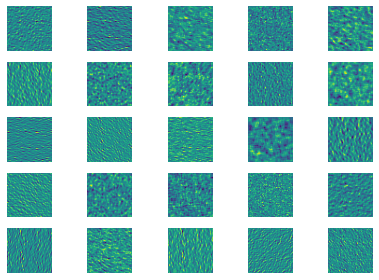

In [24]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# model = Extractor()
model.conv1.register_forward_hook(get_activation('conv1'))
x = torch.randn(1, 3, 96, 96)
output = model(x)
print(output.shape)

act = activation['conv1'].squeeze()
num_plot = 25
fig, axes = plt.subplots(5, 5)
for idx in range(min(act.size(0), num_plot)):
    axes.flat[idx].imshow(act[idx])
    axes.flat[idx].axis('off')
fig.tight_layout()
plt.show()